In [ ]:
#!git clone https://github.com/JonWinkelman/jw_utils.git
import os
import pandas as pd
from jw_utils import parse_fasta as pfa
from jw_utils import hmmer_utils as hu
from jw_utils import alignment_utils2 as au


from Bio import Phylo
from Bio import SeqIO
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.io as pio

import random

import subprocess
from concurrent.futures import ThreadPoolExecutor


1. Put all individual proteomes into one directory
2. make a dictionary {name:proteome_fp}

## Fill out path to directory containing proteomes!

In [24]:
proteome_dir_fp = '../data/Proteomes/'
proteome_suffix = '.faa'


In [27]:
prot_name_fp_d = {f.strip(proteome_suffix).strip('.'):os.path.join(proteome_dir_fp, f ) for f in os.listdir(proteome_dir_fp) if f.endswith(proteome_suffix)}
hmm_bac120_ids = [f.replace('.HMM', '') for f in os.listdir('./bac120_hmm_profiles/') if f.endswith('HMM')]
wd = os.getcwd()

def concatenate_hmm_files(directory, output_file, suffix='.HMM'):
    """
    Concatenates all files ending with '.HMM' in the given directory into one output file.

    Args:
        directory (str): Path to the directory containing .HMM files.
        output_file (str): Path to the output file where concatenated content will be saved.
    """
    with open(output_file, 'w') as outfile:
        
        for filename in os.listdir(directory):
            if filename.endswith(suffix):
                file_path = os.path.join(directory, filename)
                with open(file_path, 'r') as infile:
                    outfile.write(infile.read())
                    outfile.write('\n')  # Add a newline between files

    print(f"All .HMM files from '{directory}' concatenated into '{output_file}'.")



concatenate_hmm_files('bac120_hmm_profiles', output_file='concat_bac120_profiles.hmm')
os.makedirs('bac120hmm_db', exist_ok=True)
if os.getcwd() == wd: 
    os.chdir('./bac120hmm_db')
!hmmpress ../concat_bac120_profiles.hmm
if os.getcwd() != wd:
    os.chdir(wd)

All .HMM files from 'bac120_hmm_profiles' concatenated into 'concat_bac120_profiles.hmm'.
Working...    done.
Pressed and indexed 120 HMMs (120 names and 120 accessions).
Models pressed into binary file:   ../concat_bac120_profiles.hmm.h3m
SSI index for binary model file:   ../concat_bac120_profiles.hmm.h3i
Profiles (MSV part) pressed into:  ../concat_bac120_profiles.hmm.h3f
Profiles (remainder) pressed into: ../concat_bac120_profiles.hmm.h3p


In [109]:
def run_hmmsearch(proteome_name,proteome_fp, hmm_db, output_dir):
    """Function to run hmmsearch with multiple hmms in an indexed hmm db on a single proteome"""
    output_file = os.path.join(output_dir, f'{proteome_name}_best_hits.txt')
    tblout_file = os.path.join(output_dir, f'{proteome_name}_table.txt')
    cmd = [
        'hmmsearch', '--tblout', tblout_file, '-E', '1e-5', 
        hmm_db, proteome_fp 
    ]
    with open(output_file, 'w') as outfile:
        subprocess.run(cmd, stdout=outfile)


def ThreadPool_hmm_search(hmm_db, output_dir, prot_name_fp_d, threads = 6):
    # Use ThreadPoolExecutor to run searches in parallel
    with ThreadPoolExecutor(max_workers=threads) as executor:  # Adjust max_workers based on CPU cores
        futures = [executor.submit(run_hmmsearch, 
                                   proteome_name,
                                   proteome_fp, 
                                   hmm_db, 
                                   output_dir) for  proteome_name, proteome_fp in prot_name_fp_d.items()]

    # Wait for all futures to complete
    for future in futures:
        print(future.result())



In [111]:
hmm_db = './bac120hmm_db/concat_bac120_profiles.hmm'
hmm_output_dir = './fastTree/hmm_search_output/'
os.makedirs(hmm_output_dir, exist_ok=True)
ThreadPool_hmm_search(hmm_db, hmm_output_dir, prot_name_fp_d, threads=6)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [112]:
import pandas as pd

def parse_tblout(tblout_file):
    hits = []
    with open(tblout_file) as f:
        for line in f:
            if not line.startswith('#'):  # Skip comments
                cols = line.split()
                target = cols[0]  # target sequence
                hmm_acc = cols[3]
                e_value = float(cols[4])  # e-value of the hit
                hits.append((target, hmm_acc, e_value))
    return hits

# Aggregate results for all proteomes
hits_dict = {}
for name in prot_name_fp_d.keys():
    tblout_file = os.path.join(hmm_output_dir, f'{name}_table.txt')
    hits_dict[name] = parse_tblout(tblout_file)

In [113]:
dfs = {}
best_hits_dir = os.path.join(hmm_output_dir, 'best_hits')
os.makedirs(best_hits_dir, exist_ok=True)
pd.set_option('display.float_format', '{:.10e}'.format)
for name, hits in hits_dict.items():
    best_hit = []
    
    t = pd.DataFrame(hits, columns=['target_name', 'hmm_acc', 'e_value'])
    for hmm, df in t.groupby('hmm_acc'):
        best_hit.append(df.sort_values('e_value').iloc[0,:].to_frame().transpose())
    dfs[name] = pd.concat(best_hit).set_index('target_name')
    dfs[name].to_csv(os.path.join(best_hits_dir, f'{name}_best_hits.csv'))

### Create fasta file for each genome with bac120 proteins

In [126]:
from jw_utils import parse_fasta as pfa
# get ~120 proteins from each proteome
bac120_proteins = './fastTree/bac120_proteins'
os.makedirs(bac120_proteins, exist_ok=True)
perc = .05
for i, (name, proteome_fp) in enumerate(prot_name_fp_d.items()):
   
    if i/len(prot_name_fp_d.keys()) > perc:
        print(f'{round(i/len(prot_name_fp_d.keys())*100, 2)} percent finished.')
        perc += 0.05
    seq_d = pfa.get_seq_dict(proteome_fp)
    hmm_seq_d = {}
    for protein_id, row in dfs[name].iterrows():
        hmm_seq_d[f'{row["hmm_acc"]}'] = seq_d[protein_id]
    pfa.write_to_fasta(hmm_seq_d, os.path.join(bac120_proteins, f"{name}_bac120hits.faa"))

5.02 percent finished.
10.03 percent finished.
15.05 percent finished.
20.06 percent finished.
25.08 percent finished.
30.09 percent finished.
35.11 percent finished.
40.13 percent finished.
45.14 percent finished.
50.16 percent finished.
55.17 percent finished.
60.19 percent finished.
65.2 percent finished.
70.22 percent finished.
75.24 percent finished.
80.25 percent finished.
85.27 percent finished.
90.28 percent finished.
95.3 percent finished.


In [128]:
### grab protein from each genome and align with hmm
# make seqfile fasta for each hmm
hmm_alignments = './fastTree/hmm_alignments'
names = list(prot_name_fp_d.keys())
os.makedirs(hmm_alignments, exist_ok=True)
missing = {name:[] for name in names}
for hmm in hmm_bac120_ids:
    seq_d ={}
    for name in names:
        fp = os.path.join(bac120_proteins,f'{name}_bac120hits.faa')
        seq = pfa.get_seq_dict(fp).get(hmm)
        if seq:
            seq_d[name] = seq
            missing[name].append(True)
        else:
            missing[name].append(False)
    pfa.write_to_fasta(seq_d, os.path.join(hmm_alignments, f"{hmm}.faa"))
pres_abs_df = pd.DataFrame.from_dict(missing, orient='index', columns=hmm_bac120_ids)    

In [131]:
sto_fps = []
for hmm in hmm_bac120_ids:
    """"""
    print(f'aligning with {hmm}...')
    seqs_fp = os.path.join(hmm_alignments,f'{hmm}.faa')
    out_fp = seqs_fp.replace('.faa', '.sto')
    hu.run_hmm_alignment(hmm_db,seqs_fp,hmm, out_fp, output_format='Pfam', trim=True)
    sto_fps.append(out_fp)

aligning with PF01025.23...
aligning with TIGR01171.1...
aligning with TIGR01029.1...
aligning with TIGR01953.1...
aligning with TIGR02386.1...
aligning with TIGR00459.1...
aligning with TIGR00088.1...
aligning with TIGR03632.1...
aligning with TIGR01032.1...
aligning with TIGR01951.1...
aligning with TIGR00029.2...
aligning with TIGR00392.1...
aligning with TIGR00442.1...
aligning with TIGR00810.1...
aligning with TIGR00168.2...
aligning with TIGR00663.1...
aligning with TIGR00396.1...
aligning with TIGR03594.1...
aligning with TIGR00643.1...
aligning with TIGR02729.1...
aligning with TIGR00337.1...
aligning with TIGR00116.1...
aligning with TIGR00460.1...
aligning with TIGR01009.1...
aligning with TIGR00580.1...
aligning with TIGR00250.1...
aligning with PF00410.23...
aligning with TIGR01071.1...
aligning with TIGR01394.1...
aligning with TIGR00095.1...
aligning with PF00380.23...
aligning with TIGR00928.1...
aligning with TIGR01017.1...
aligning with TIGR01393.1...
aligning with TIG

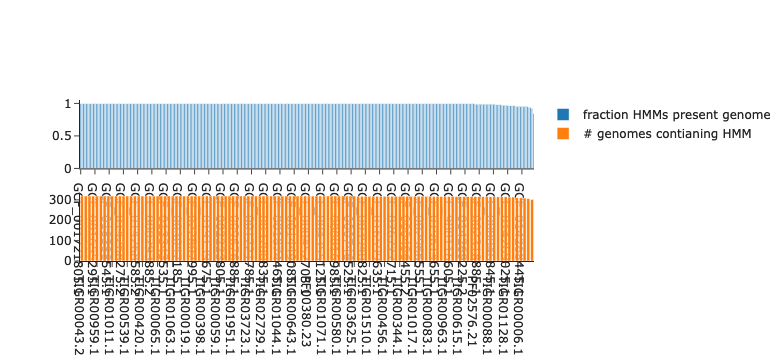

In [132]:
qc_fig = make_subplots(rows=2, cols=1,)
hmm_pres_s = pres_abs_df.sum().sort_values(ascending=False)
genome_pres_s = (pres_abs_df.sum(axis=1)/len(hmm_bac120_ids)).sort_values(ascending=False)
hmm_trace = go.Bar(x=hmm_pres_s.index, y = hmm_pres_s, name='# genomes contianing HMM')
g_trace = go.Bar(x=genome_pres_s.index, y = genome_pres_s, name='fraction HMMs present genome')
qc_fig.add_trace(g_trace, row=1, col=1, )
qc_fig.add_trace(hmm_trace, row=2, col=1, )
qc_fig.update_layout(template='simple_white', height=600)
remove = list(genome_pres_s.index[-20:])
qc_fig

In [133]:
def remove_pp_lines(hmm_alignment_fp):
    """"""
    new_aln = []
    new_aln_d = {}
    with open(hmm_alignment_fp, 'r') as f:
        for line in f:
            if line[0] != '#':
                if len(line) > 5:
                    if line[0] != '/':
                        line_lst = line.strip().split(' ')
                        seq = line_lst[-1].replace('.', '-')
                        new_aln_d[line_lst[0]] = seq.upper()
    return new_aln_d
    
    
def write_reformatted_aln_file(sto_alignment_fp, homogeneos_thresh=0.98, gap_threshold=0.8):
    """"""
    reformatted_alinged_d = remove_pp_lines(sto_alignment_fp)
    trimmed_seq_d= au.remove_homogeneous_cols(reformatted_alinged_d, threshold=homogeneos_thresh)
    trimmed_seq_d = au.remove_gappy_columns(trimmed_seq_d, threshold=gap_threshold)
    reformatted_align_fp = sto_alignment_fp.replace('sto', 'sto.simple')
    pfa.write_to_fasta(trimmed_seq_d, reformatted_align_fp)
    return trimmed_seq_d


simple_aln_fps = []
for fp in sto_fps: 
    reformatted_alinged_d = write_reformatted_aln_file(fp)
    seq_d = pfa.get_seq_dict(fp)

    simple_aln_fps.append(fp.replace('sto', 'sto.simple'))
    

In [134]:
from Bio import SeqIO
import os
from collections import defaultdict
curated_accs = set(names).difference(remove)
# Path to the directory with 120 aligned FASTA files
fasta_dir = './fastTree/hmm_alignments'
# Dictionary to store concatenated sequences for each genome
concatenated_sequences = defaultdict(str)
# Get a list of all FASTA files in the directory
fasta_files = sorted([f for f in os.listdir(fasta_dir) if f.endswith('.simple')])

# Loop over each FASTA file and concatenate sequences by genome accession
for fasta_file in fasta_files[:30]:
    fasta_path = os.path.join(fasta_dir, fasta_file)
    seq_d = pfa.get_seq_dict(fasta_path)
    aln_len = len(seq_d[list(seq_d.keys())[0]])
    for acc in curated_accs:
        seq = seq_d.get(acc, '-'*aln_len)
        concatenated_sequences[acc] += seq

# Write the concatenated sequences to a new FASTA file
output_fasta = './fastTree/concatenated_alignment.fasta'
with open(output_fasta, 'w') as output_handle:
    for genome_accession, concatenated_seq in concatenated_sequences.items():
        output_handle.write(f'>{genome_accession}\n')
        output_handle.write(f'{concatenated_seq}\n')

In [135]:
!fasttree fastTree/concatenated_alignment.fasta > fastTree/tree.nwk

FastTree Version 2.1.11 Double precision (No SSE3)
Alignment: fastTree/concatenated_alignment.fasta
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Ignored unknown character X (seen 1 times)
Initial topology in 1.08 seconds0 of    265   268 seqs (at seed    200)   
Refining topology: 32 rounds ME-NNIs, 2 rounds ME-SPRs, 16 rounds ML-NNIs
Total branch-length 10.008 after 8.51 sec, 1 of 266 splits   16 changes (max delta 0.026)   
ML-NNI round 1: LogLk = -191687.327 NNIs 50 max delta 37.59 Time 23.02s (max delta 37.593)   
Switched to using 20 rate categories (CAT approximation)20 of 20   
Rate categories were divided by 1.002 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI